In [1]:
import numpy as np
from matplotlib import pyplot as plt
import cv2
import pathlib

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

### FaceBoxes.Pytorch `test.py` imports 
* Removed nms references to evaluate on CPU

In [3]:
import os
import torch
import torch.backends.cudnn as cudnn

from data import cfg
from layers.functions.prior_box import PriorBox
from models.faceboxes import FaceBoxes
from utils.box_utils import decode
from utils.timer import Timer
from utils.custom import nms_cpu, check_keys, load_model, remove_prefix

In [14]:
def load_faceboxes():
    """
    Load FaceBoxes model and weight in pytorch
    """

    pretrained_path = 'weights/FaceBoxes.pth'
    args_cuda = False

    # net and model
    net = FaceBoxes(phase='test', size=None, num_classes=2)    # initialize detector
    net = load_model(net, pretrained_path)
    net.eval()
    print('Finished loading model')
    return net.cpu()

net = load_faceboxes()

Loading pretrained model from weights/FaceBoxes.pth
remove prefix 'module.'
Missing keys:27
Unused checkpoint keys:0
Used keys:147
Finished loading model


boxes after threshold: 24
forward pass: 0.0099 s
Applying Non-Max Supression 
Face boxes: 1
Forward pass and nms: 0.0010 s

 ----------------------------------------------------------------------
[array([ 80.01741   ,  44.324486  , 113.05879   ,  84.40432   ,
         0.99002576], dtype=float32)]


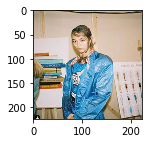

In [15]:

def get_facebox_coords(img, net):
    """
    Evaluates faceboxes forward pass and NMS
        returns dets, faceboxes array of [x1, x2, y1, y2, score]
    """

    im_height, im_width, _ = img.shape
    scale = torch.Tensor([img.shape[1], img.shape[0], img.shape[1], img.shape[0]])
    img -= (104, 117, 123)
    img = img.transpose(2, 0, 1)
    img = torch.from_numpy(img).unsqueeze(0)

    # ========================================================== #
    # Forward pass evaluation                                    #
    # ========================================================== #

    _t['forward_pass'].tic()
    out = net(img)  # forward pass
    _t['forward_pass'].toc()
    _t['nms'].tic()

    priorbox = PriorBox(cfg, out[2], (im_height, im_width), phase='test')
    priors = priorbox.forward()

    loc, conf, _ = out
    prior_data = priors.data
    boxes = decode(loc.data.squeeze(0), prior_data, cfg['variance'])
    boxes = boxes * scale / resize
    boxes = boxes.cpu().numpy()
    scores = conf.data.cpu().numpy()[:, 1]


    # ========================================================== #
    confidence_threshold = 0.05
    top_k = 400
    # ========================================================== #

    # ignore low scores
    inds = np.where(scores > confidence_threshold)[0]
    boxes = boxes[inds]
    scores = scores[inds]

    # keep top-K scores before NMS
    order = scores.argsort()[::-1][:top_k]
    boxes = boxes[order]
    scores = scores[order]

    # Number of output predictions after thresholding
    print('boxes after threshold:', len(scores))
    print('forward pass: {:.4f} s'.format(_t['forward_pass'].average_time))

    # ================= Note: NMS implemented ===================== #

    nms_threshold = 0.3
    keep_top_k = 10

    # do NMS
    dets = np.hstack((boxes, scores[:, np.newaxis])).astype(np.float32, copy=False)
    keep = nms_cpu(dets, nms_threshold)
    dets = dets[keep, :]

    # Trim results above top-K
    dets = dets[:keep_top_k]
    _t['nms'].toc()

    if len(dets.shape) == 1:  # edge case where nms has a single return
        dets = [dets]
        
    print('Applying Non-Max Supression \nFace boxes:', len(dets))
    print('Forward pass and nms: {:.4f} s'.format(_t['nms'].average_time))
    return dets

    
# --------------------- Load image -------------------------
path = pathlib.Path.cwd()
image_path = path/'data/lfw_224x224.jpg'
#image_path = path/'data/pedestrians_224.jpg'
#image_path = path/'data/t1.jpg'
resize = 1
_t = {'forward_pass': Timer(), 'nms': Timer()}

# ---------------- Image transformations -------------------
image = cv2.imread(str(image_path), cv2.IMREAD_COLOR)
img = np.float32(image)
RGB_im = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# ----------------------------------------------------------

# Resizing
if resize != 1:
    img = cv2.resize(img, None, None, fx=resize, fy=resize, interpolation=cv2.INTER_LINEAR)
# Preview
plt.rcParams['figure.figsize'] = (2, 2)
plt.imshow(RGB_im)


dets = get_facebox_coords(img, net)
print('\n','-'*70)
print(dets)

In [20]:
fps = 'FPS: {:.2f}'.format(1 / 0.22222)
fps

'FPS: 4.50'

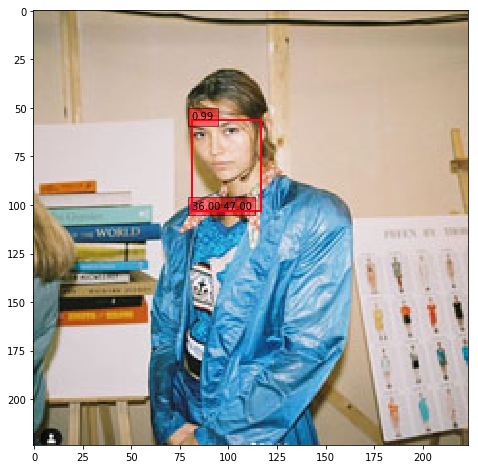

In [12]:
# ================== Plot the boxes ================== #

plt.rcParams['figure.figsize'] = (8, 8)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
colors = plt.cm.hsv(np.linspace(0, 1, 2)).tolist()
plt.imshow(RGB_im)
currentAxis = plt.gca()


    
# loop and draw boxes
for det in dets:
    xmin = int(round(det[0]))
    ymin = int(round(det[1]))
    xmax = int(round(det[2]))
    ymax = int(round(det[3]))
    score = det[4]
    display_txt = '%.2f' % (score)
    display_wh = '%.2f %.2f' % (xmax-xmin+1, ymax-ymin+1)
    coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
    color = colors[1]
    currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
    currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':color, 'alpha': 0.5})
    currentAxis.text(xmin, ymax, display_wh, bbox={'facecolor': color, 'alpha': 0.5})
